In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import datetime

In [110]:
df_price = pd.read_csv(os.path.join('005930.KS.csv'), encoding='utf8')
df_price.describe()
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-03,25900.0,25940.0,25720.0,25800.0,260.387482,8334750.0
1,2015-12-04,25500.0,25600.0,25340.0,25380.0,256.148621,9635550.0
2,2015-12-07,25380.0,25500.0,25240.0,25240.0,254.735657,9805350.0
3,2015-12-08,25240.0,25440.0,25240.0,25240.0,254.735657,6916100.0
4,2015-12-09,25240.0,25500.0,25240.0,25260.0,254.937500,9090600.0


In [111]:
df_price = df_price.dropna()

In [112]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df_price[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close    Volume
0     0.088765  0.069433  0.085088  0.069817  0.128859
1     0.080189  0.062235  0.076923  0.060877  0.148970
2     0.077616  0.060119  0.074774  0.057897  0.151595
3     0.074614  0.058848  0.074774  0.057897  0.106926
4     0.074614  0.060119  0.074774  0.058323  0.140544
...        ...       ...       ...       ...       ...
1215  0.950686  0.959780  0.950580  0.968072  0.294109
1216  0.991424  0.968247  0.984959  0.972329  0.217427
1217  1.000000  0.972481  0.965621  0.940400  0.677337
1218  0.972127  0.966130  0.974216  0.963814  0.345187
1219  1.000000  1.000000  1.000000  1.000000  0.429767

[1220 rows x 5 columns]


In [113]:
train = df_scaled[:-300]
test = df_scaled[-300:]

In [114]:
def make_dataset(data, label, window_size=50):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [115]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((280, 20, 4), (280, 1))

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, input_shape=(20,4), activation='relu', return_sequences=False))
model.add(Dense(1))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 16)                1344      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [117]:
model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5) #overfitting 방지
filename = os.path.join('tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/20
40/45 [=========================>....] - ETA: 0s - loss: 0.0457
Epoch 00001: val_loss improved from inf to 0.00271, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 9ms/step - loss: 0.0410 - val_loss: 0.0027
Epoch 2/20
36/45 [=======================>......] - ETA: 0s - loss: 0.0013
Epoch 00002: val_loss improved from 0.00271 to 0.00080, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 7.9865e-04
Epoch 3/20
41/45 [==========================>...] - ETA: 0s - loss: 7.1871e-04
Epoch 00003: val_loss improved from 0.00080 to 0.00069, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 5ms/step - loss: 7.1671e-04 - val_loss: 6.8902e-04
Epoch 4/20
39/45 [=========================>....] - ETA: 0s - loss: 7.0534e-04
Epoch 00004: val_loss improved from 0.00069 to 0.00067, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 5ms/step - loss: 6.

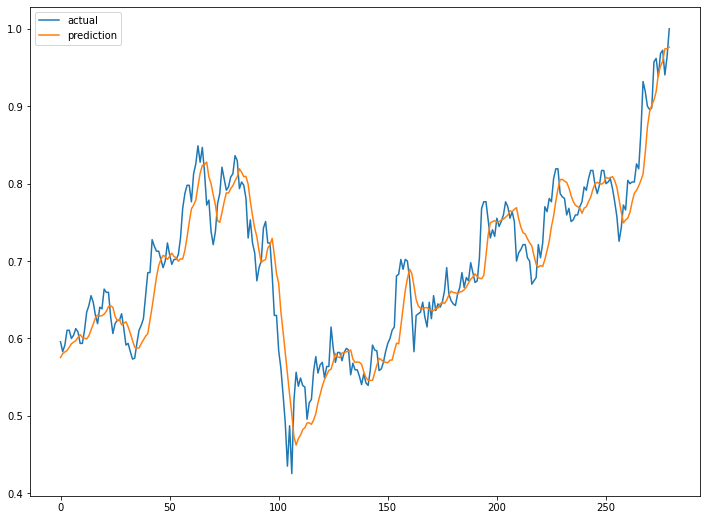

In [118]:
model.load_weights(filename)
pred = model.predict(test_feature)

plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()